In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
sys.path.append('C:\\Users\\Graúna Motos\\Documents\\credit_risk')
#sys.path.append('/home/noise/Documentos/credit_risk')
from src.utils_modelling import analisy_univariate, wo_discretize, plot_woe, wo_discretize_continuos, CatImputer, CatCombiner, CatOneHotEncoder, DiscretizerCombiner
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from src.utils_modelling import LogisticRegressionPvalues
import mlflow
import warnings
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

In [2]:
#df = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_2007_2014.csv')

In [3]:
df = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\bronze\\loan_data_2007_2014 (1).csv')

In [4]:
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.width = None
'''

'\npd.options.display.max_rows = None\npd.options.display.max_columns = None\npd.options.display.width = None\n'

In [5]:
def clean(value):
    if pd.isna(value):
        return 0
    elif '10+' in value:
        return 10
    elif '<' in value:
        return 0
    else:
        return float(value.split()[0])
    
df['emp_length_int'] = df['emp_length'].apply(clean)

In [6]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')
pd.to_datetime('2017-12-01') - df['earliest_cr_line_date'] 

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [7]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['earliest_cr_line_date']) / np.timedelta64(1, 'm')))

In [8]:
df.loc[:, ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-23536800.0
1770,Sep-68,2068-09-01,-26693280.0
2799,Sep-64,2064-09-01,-24589440.0
3282,Sep-67,2067-09-01,-26166240.0
3359,Feb-65,2065-02-01,-24809760.0
...,...,...,...
464003,Jan-68,2068-01-01,-26341920.0
464260,Jul-66,2066-07-01,-25551360.0
465100,Oct-67,2067-10-01,-26209440.0
465500,Sep-67,2067-09-01,-26166240.0


In [9]:
df['emp_length_int']

0         10.0
1          0.0
2         10.0
3         10.0
4          1.0
          ... 
466280     4.0
466281    10.0
466282     7.0
466283     3.0
466284    10.0
Name: emp_length_int, Length: 466285, dtype: float64

In [10]:
df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()

In [11]:
min(df['mths_since_earliest_cr_line'])

3199680.0

In [12]:
def clean_term(value):
    if pd.isna(value):
        return 0
    elif ' 36 months' in value:
        return 36
    elif ' 60 months' in value:
        return 60
    else:
        return float(value.split()[0])
df['term_int'] = df['term'].apply(clean_term)

In [13]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')

In [14]:
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['issue_d_date'])/np.timedelta64(1, 'm')))

In [15]:
threshold = 10
categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() < threshold]
print("Variáveis categóricas confirmadas:", categorical_columns)


Variáveis categóricas confirmadas: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'application_type']


In [16]:
remover = ['id', 'member_id', 'url', 
                      'Unnamed: 0', 'next_pymnt_d', 
                      'application_type', 'pymnt_plan', 
                      'policy_code', 'zip_code', 'title',
                      'emp_title', 'last_pymnt_d', 'last_credit_pull_d',
                      'funded_amnt_inv', 'total_pymnt_inv', 'out_prncp_inv']

df = df.drop(columns=remover)

In [17]:
missings = ['annual_inc', 'total_acc', 'acc_now_delinq', 'pub_rec', 'open_acc', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths']
df = df.dropna(subset=missings)

In [18]:
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']), 0, 1)

In [19]:
def select_features(df):
    """
    Seleciona apenas as features especificadas.
    
    Args:
        df (pd.DataFrame): DataFrame de entrada
        
    Returns:
        pd.DataFrame: DataFrame apenas com as features selecionadas
    """
    # Lista de features para manter
    features_to_keep = [
        'loan_amnt',
        'funded_amnt', 
        'term',
        'int_rate',
        'installment',
        'grade',
        'sub_grade',
        'emp_length',
        'home_ownership',
        'annual_inc',
        'verification_status',
        'issue_d',
        'loan_status',
        'purpose',
        'addr_state',
        'dti',
        'delinq_2yrs',
        'inq_last_6mths',
        'mths_since_last_delinq',
        'open_acc',
        'pub_rec',
        'revol_bal',
        'revol_util',
        'total_acc',
        'initial_list_status',
        'out_prncp',
        'total_pymnt',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_pymnt_amnt',
        'collections_12_mths_ex_med',
        'acc_now_delinq',
        'tot_coll_amt',
        'tot_cur_bal',
        'total_rev_hi_lim',
        'mths_since_earliest_cr_line',
        'default',
        'recovery_rate',
        'credit_conversion_factor',
        'good_bad'
    ]
    
    # Seleciona apenas as features disponíveis
    available_features = [col for col in features_to_keep if col in df.columns]
    df_selected = df[available_features].copy()
    
    print(f"\nShape final do DataFrame: {df_selected.shape}")
    print(f"Total de features mantidas: {len(df_selected.columns)}")
    
    return df_selected

In [20]:
df = select_features(df)


Shape final do DataFrame: (466256, 40)
Total de features mantidas: 40


In [21]:
data_leakage_features = ['funded_amnt', 'installment', 'revol_util', 
                         'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 
                         'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                         'last_pymnt_amnt', 'collections_12_mths_ex_med', 'tot_coll_amt']
irrelevant_features = ['delinq_2yrs', 'acc_now_delinq', 'pub_rec', 'total_rev_hi_lim', 
                         'loan_status']
to_drop = data_leakage_features + irrelevant_features
df = df.drop(columns=to_drop)
df.shape

(466256, 22)

In [22]:
df.head()

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,dti,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,total_acc,initial_list_status,tot_cur_bal,mths_since_earliest_cr_line,good_bad
0,5000,36 months,10.65,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,...,27.65,1.0,NaN,3.0,13648,9.0,f,NaN,17311680.0,1
1,2500,60 months,15.27,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,...,1.00,5.0,NaN,3.0,1687,4.0,f,NaN,9819360.0,0
2,2400,36 months,15.96,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,...,8.72,2.0,NaN,2.0,2956,10.0,f,NaN,8458560.0,1
3,10000,36 months,13.49,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,...,20.00,1.0,35.0,10.0,5598,37.0,f,NaN,11482560.0,1
4,3000,60 months,12.69,B,B5,1 year,RENT,80000.0,Source Verified,Dec-11,...,17.94,0.0,38.0,15.0,27783,38.0,f,NaN,11527200.0,1


In [23]:
train, test = np.split(df, [int(.80 * len(df))])
train['set'] = 'train'
test['set'] = 'test'

In [24]:
to_drop = ['issue_d', 'set']
train = train.drop(columns=to_drop)
test = test.drop(columns=to_drop)

In [25]:
X_train = train.drop(columns=['good_bad'])
y_train = train['good_bad'].copy()
X_test = test.drop(columns=['good_bad'])
y_test = test['good_bad'].copy()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((373004, 20), (373004,), (93252, 20), (93252,))

In [26]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.width = None

In [27]:
X_train.head(5)

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,inq_last_6mths,mths_since_last_delinq,open_acc,revol_bal,total_acc,initial_list_status,tot_cur_bal,mths_since_earliest_cr_line
0,5000,36 months,10.65,B,B2,10+ years,RENT,24000.0,Verified,credit_card,AZ,27.65,1.0,NaN,3.0,13648,9.0,f,NaN,17311680.0
1,2500,60 months,15.27,C,C4,< 1 year,RENT,30000.0,Source Verified,car,GA,1.00,5.0,NaN,3.0,1687,4.0,f,NaN,9819360.0
2,2400,36 months,15.96,C,C5,10+ years,RENT,12252.0,Not Verified,small_business,IL,8.72,2.0,NaN,2.0,2956,10.0,f,NaN,8458560.0
3,10000,36 months,13.49,C,C1,10+ years,RENT,49200.0,Source Verified,other,CA,20.00,1.0,35.0,10.0,5598,37.0,f,NaN,11482560.0
4,3000,60 months,12.69,B,B5,1 year,RENT,80000.0,Source Verified,other,OR,17.94,0.0,38.0,15.0,27783,38.0,f,NaN,11527200.0


In [28]:
class CatImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.impute_mapping = {  # Corrigido o nome do atributo
            'mths_since_last_delinq': 'never_delinquent',
            'tot_cur_bal': 'missing',
        }
        self.missing = 'nan'

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        x_copy = x.copy()  # Corrigido para chamar o método copy()

        for feature, impute_value in self.impute_mapping.items():  # Corrigido o nome das variáveis
            x_copy[feature] = x_copy[feature].replace(self.missing, impute_value)  # Corrigido o nome das variáveis

        return x_copy


class CatCombiner(BaseEstimator, TransformerMixin):  # Corrigido o nome da classe e herança
    def __init__(self, debug=False):
        self.category_mapping = {
            'grade': [],
            'home_ownership': [['OTHER', 'NONE', 'RENT', 'ANY']],  # Corrigido o nome do campo
            'purpose': [
                ['small_business', 'educational', 'renewable_energy', 'moving'],
                ['other', 'house', 'medical', 'vacation'],
                ['wedding', 'home_improvement', 'major_purchase', 'car'],
            ],
            'addr_state': [
                ['NE', 'IA', 'NV', 'HI', 'FL'],
                ['AL', 'NM', 'NJ'],
                ['OK', 'MO', 'MD', 'NC'],
                ['AR', 'TN', 'MI', 'UT', 'VA', 'LA', 'PA', 'AZ', 'OH', 'RI', 'KY', 'DE', 'IN'],
                ['MA', 'SD', 'GA', 'MN', 'WI', 'WA', 'OR', 'IL', 'CT'],
                ['MS', 'MT', 'SC', 'VT', 'KS', 'CO', 'AK', 'NH', 'WV', 'WY', 'ID', 'DC', 'ME'],
            ],
            'initial_list_status': [],
            'verification_status': [],
            'sub_grade': [
                ['G1', 'F5', 'G5', 'G3', 'G2', 'F4', 'F3', 'G4', 'F2'],
                ['E5', 'F1', 'E4', 'E3', 'E2'],
                ['E1', 'D5', 'D4'],
                ['D3', 'D2', 'D1'],
                ['C5', 'C4', 'C3'],
                ['C2', 'C1', 'B5'],
                ['B4', 'B3'],
                ['B2', 'B1'],
                ['A5', 'A4'],
                ['A3', 'A2', 'A1']
            ],
            'term': [],
            'emp_length': [
                [1, 3],
                [4, 6],
                [7, 9]
            ],
            'inq_last_6mths': [
                [4, 33]
            ],
        }
        self.debug = debug

    def fit(self, X, y=None):
        return self

    def transform(self, x):
        x_copy = x.copy()

        for feature, category_groups in self.category_mapping.items():
            for category_group in category_groups:
                if all(isinstance(element, str) for element in category_group):
                    bundled_category = '_'.join(category_group)
                    to_replace = category_group
                else:
                    bundled_category = f'{category_group[0]}-{category_group[-1]}'  # Corrigido o acesso ao índice
                    to_replace = range(category_group[0], category_group[-1] + 1)  # Corrigido o acesso ao índice

                x_copy[feature] = x_copy[feature].replace(to_replace, bundled_category)

            x_copy[feature] = x_copy[feature].astype(str)

            if self.debug:
                print(f'Categorias de pacotes de {feature}')  # Corrigido nome da variável
                print(f'Categorias originais {x[feature].unique().tolist()}')
                print(f'Novas categorias: {x_copy[feature].unique().tolist()}')

        return x_copy


class DiscretizerCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, debug=False):  # Corrigido o nome do parâmetro
        self.category_mapping = {
            'int_rate': [7, 10, 12, 14, 16, 18, 22],
            'loan_amnt': [7400, 14300, 21200, 28100],
            'dti': [4, 8, 12, 16, 20, 28],
            'annual_inc': [20000, 40000, 60000, 75000, 90000, 120000, 150000],
            'mths_since_earliest_cr_line': [151, 226, 276, 401],
            'revol_bal': [2000, 6000, 12000, 22000, 30000, 36000, 40000],
            'tot_cur_bal': [80000, 140000, 200000, 240000, 280000, 340000, 400000],
            'mths_since_last_delinq': [4, 7, 22, 37, 74],
            'open_acc': [6, 12, 21],
            'total_acc': [8, 15, 24, 36],
        }
        self.debug = debug

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        for feature, category_bins in self.category_mapping.items():
            bins = [-float('inf')] + category_bins + [float('inf')]
            labels = []

            first_bin_label = f'<={category_bins[0] / 1000:.1f}K' if category_bins[0] >= 1000 else f'<={category_bins[0]:.1f}'
            labels.append(first_bin_label)

            for i in range(1, len(category_bins)):
                lower_bound = category_bins[i-1] / 1000 if category_bins[i-1] >= 1000 else category_bins[i-1]
                upper_bound = category_bins[i] / 1000 if category_bins[i] >= 1000 else category_bins[i]
                bin_label = f'{lower_bound:.1f}K-{upper_bound:.1f}K' if category_bins[i] >= 1000 else f'{lower_bound:.1f}-{upper_bound:.1f}'
                labels.append(bin_label)

            last_bin_label = f'>{category_bins[-1] / 1000:.1f}K' if category_bins[-1] >= 1000 else f'>{category_bins[-1]:.1f}'
            labels.append(last_bin_label)

            X_copy[feature] = pd.cut(X_copy[feature], bins=bins, labels=labels, include_lowest=False, right=True)
            X_copy[feature] = X_copy[feature].astype(str)

            if self.debug:
                print(f'Discretize and bundle categories of {feature}.')
                print(f'Original range: {round(X[feature].min())} to {round(X[feature].max())}.')
                print(f'Discretized and bundled categories: {X_copy[feature].unique().tolist()}.')
                print()

        return X_copy


class CatOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Assegure-se de que há uma categoria de referência para cada feature possível
        self.reference_categories = {
            'loan_amnt': '>28.1K',
            'term': '60',
            'int_rate': '>22.0',
            'grade': 'G',
            'sub_grade': 'G1_F5_G5_G3_G2_F4_F3_G4_F2',
            'emp_length': '0',
            'home_ownership': 'OTHER_NONE_RENT_ANY',
            'annual_inc': '<=20.0K',
            'verification_status': 'Verified',
            'purpose': 'small_business_educational_renewable_energy_moving',
            'addr_state': 'NE_IA_NV_HI_FL',
            'dti': '>28.0',
            'inq_last_6mths': '4-33',
            'open_acc': '<=4.0',
            'total_acc': '<=6.0',
            'revol_bal': '<=2.0K',
            'mths_since_last_delinq': '<=8.0',
            'initial_list_status': 'f',
            'tot_cur_bal': 'missing',
            'mths_since_earliest_cr_line': '<=151.0'
        }
        self.encoder = None

    def fit(self, X, y=None):
        # Criar lista de categorias para drop baseada nas colunas presentes
        drop_categories = []
        for column in X.columns:
            ref_cat = self.reference_categories.get(column)
            if ref_cat is not None and ref_cat in X[column].unique():
                drop_categories.append(ref_cat)
            else:
                # Se não houver categoria de referência, use a primeira categoria
                first_cat = X[column].unique()[0]
                drop_categories.append(first_cat)

        # Configurar o OneHotEncoder
        self.encoder = OneHotEncoder(
            drop=drop_categories,
            sparse_output=False,
            dtype=np.int8,
            handle_unknown='ignore'
        )
        self.encoder.fit(X)
        return self

    def transform(self, X):
        if self.encoder is None:
            raise RuntimeError("The encoder must be fitted before calling transform.")
        X_one_hot = self.encoder.transform(X)
        one_hot_df = pd.DataFrame(
            X_one_hot, 
            columns=self.encoder.get_feature_names_out(),
            index=X.index
        )
        return one_hot_df


In [29]:

class LogisticRegressionWithPvalues:
   
    def __init__(self, alpha=0, method='l1'):
        self.alpha = alpha
        self.method = method
        self.model = None

    def fit(self, X, y):
        
        X_copy = X.copy()
        X_copy = sm.add_constant(X_copy)
        y_reshaped = y.values.reshape(-1,1)
        self.model = sm.Logit(y_reshaped, X_copy).fit_regularized(alpha=self.alpha, method=self.method)
        

    def predict(self, X):
    
        X_copy = X.copy()
        X_copy = sm.add_constant(X_copy)
        predicted_probabilities = self.model.predict(X_copy)
        
        return predicted_probabilities
        
   
    
    def get_summary_table(self):
        summary = self.model.summary2().tables[1]
        summary['Wald'] = summary['z'] ** 2
        summary_table = summary[['Coef.', 'P>|z|', 'Wald']]
        summary_table.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
        summary_table = summary_table.sort_index()   
        return summary_table
        
        

In [30]:
pipe = Pipeline(
    steps=[
        ('discretizer_combiner', DiscretizerCombiner()),
        ('cat_combiner', CatCombiner()),
        ('cat_imputer', CatImputer()),
        ('cat_one_hot_encoder', CatOneHotEncoder())
    ]
) 

X_train_prepared = pipe.fit_transform(X_train)
X_test_prepared = pipe.transform(X_test)
X_train_prepared.shape, X_test_prepared.shape

((373004, 100), (93252, 100))

In [31]:
X_train_prepared.head(5)

,loan_amnt_14.3K-21.2K,loan_amnt_21.2K-28.1K,loan_amnt_7.4K-14.3K,loan_amnt_<=7.4K,term_ 60 months,int_rate_10.0-12.0,int_rate_12.0-14.0,int_rate_14.0-16.0,int_rate_16.0-18.0,int_rate_18.0-22.0,int_rate_7.0-10.0,int_rate_<=7.0,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,sub_grade_A3_A2_A1,sub_grade_A5_A4,sub_grade_B2_B1,sub_grade_B4_B3,sub_grade_C2_C1_B5,sub_grade_C5_C4_C3,sub_grade_D3_D2_D1,sub_grade_E1_D5_D4,sub_grade_E5_F1_E4_E3_E2,emp_length_1 year,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_nan,home_ownership_MORTGAGE,home_ownership_OWN,annual_inc_120.0K-150.0K,annual_inc_20.0K-40.0K,annual_inc_40.0K-60.0K,annual_inc_60.0K-75.0K,annual_inc_75.0K-90.0K,annual_inc_90.0K-120.0K,annual_inc_>150.0K,verification_status_Not Verified,verification_status_Source Verified,purpose_credit_card,purpose_debt_consolidation,purpose_other_house_medical_vacation,purpose_wedding_home_improvement_major_purchase_car,addr_state_AL_NM_NJ,addr_state_AR_TN_MI_UT_VA_LA_PA_AZ_OH_RI_KY_DE_IN,addr_state_CA,addr_state_MA_SD_GA_MN_WI_WA_OR_IL_CT,addr_state_MS_MT_SC_VT_KS_CO_AK_NH_WV_WY_ID_DC_ME,addr_state_NY,addr_state_OK_MO_MD_NC,addr_state_TX,dti_12.0-16.0,dti_16.0-20.0,dti_20.0-28.0,dti_4.0-8.0,dti_8.0-12.0,dti_<=4.0,inq_last_6mths_0.0,inq_last_6mths_1.0,inq_last_6mths_2.0,inq_last_6mths_3.0,mths_since_last_delinq_22.0-37.0,mths_since_last_delinq_37.0-74.0,mths_since_last_delinq_4.0-7.0,mths_since_last_delinq_7.0-22.0,mths_since_last_delinq_<=4.0,mths_since_last_delinq_>74.0,open_acc_12.0-21.0,open_acc_6.0-12.0,open_acc_>21.0,revol_bal_12.0K-22.0K,revol_bal_2.0K-6.0K,revol_bal_22.0K-30.0K,revol_bal_30.0K-36.0K,revol_bal_36.0K-40.0K,revol_bal_6.0K-12.0K,revol_bal_>40.0K,total_acc_15.0-24.0,total_acc_24.0-36.0,total_acc_<=8.0,total_acc_>36.0,initial_list_status_w,tot_cur_bal_140.0K-200.0K,tot_cur_bal_200.0K-240.0K,tot_cur_bal_240.0K-280.0K,tot_cur_bal_280.0K-340.0K,tot_cur_bal_340.0K-400.0K,tot_cur_bal_80.0K-140.0K,tot_cur_bal_<=80.0K,tot_cur_bal_>400.0K
0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [32]:
reference_categories = pipe.named_steps['cat_one_hot_encoder'].reference_categories
reference_categories

{'loan_amnt': '>28.1K',
 'term': '60',
 'int_rate': '>22.0',
 'grade': 'G',
 'sub_grade': 'G1_F5_G5_G3_G2_F4_F3_G4_F2',
 'emp_length': '0',
 'home_ownership': 'OTHER_NONE_RENT_ANY',
 'annual_inc': '<=20.0K',
 'verification_status': 'Verified',
 'purpose': 'small_business_educational_renewable_energy_moving',
 'addr_state': 'NE_IA_NV_HI_FL',
 'dti': '>28.0',
 'inq_last_6mths': '4-33',
 'open_acc': '<=4.0',
 'total_acc': '<=6.0',
 'revol_bal': '<=2.0K',
 'mths_since_last_delinq': '<=8.0',
 'initial_list_status': 'f',
 'tot_cur_bal': 'missing',
 'mths_since_earliest_cr_line': '<=151.0'}

In [33]:

log_reg = LogisticRegressionWithPvalues(alpha=1, method='l1')
log_reg.fit(X_train_prepared, y_train)

Iteration limit reached    (Exit mode 9)
            Current function value: 0.3264212634448177
            Iterations: 1000
            Function evaluations: 1000
            Gradient evaluations: 1000


In [34]:
sumary = log_reg.get_summary_table()
sumary

,Beta Coefficient,P-Value,Wald Statistic
addr_state_AL_NM_NJ,0.078567,4.311336e-03,8.147803e+00
addr_state_AR_TN_MI_UT_VA_LA_PA_AZ_OH_RI_KY_DE_IN,0.151058,1.371399e-13,5.474626e+01
addr_state_CA,0.081688,1.527639e-04,1.433783e+01
addr_state_MA_SD_GA_MN_WI_WA_OR_IL_CT,0.229115,4.678789e-27,1.160312e+02
addr_state_MS_MT_SC_VT_KS_CO_AK_NH_WV_WY_ID_DC_ME,0.394530,2.204557e-44,1.953102e+02
addr_state_NY,0.089187,2.685003e-04,1.327827e+01
addr_state_OK_MO_MD_NC,0.098995,9.638934e-05,1.520614e+01
addr_state_TX,0.273045,4.249680e-25,1.070920e+02
annual_inc_120.0K-150.0K,0.737604,1.162294e-46,2.057492e+02
annual_inc_20.0K-40.0K,0.069911,8.070898e-02,3.050567e+00


In [35]:

sumary['P-Value'] = sumary['P-Value'].map(lambda x: f"{x:.20f}")

In [36]:
sumary

,Beta Coefficient,P-Value,Wald Statistic
addr_state_AL_NM_NJ,0.078567,0.00431133626143262623,8.147803e+00
addr_state_AR_TN_MI_UT_VA_LA_PA_AZ_OH_RI_KY_DE_IN,0.151058,0.00000000000013713987,5.474626e+01
addr_state_CA,0.081688,0.00015276391221089137,1.433783e+01
addr_state_MA_SD_GA_MN_WI_WA_OR_IL_CT,0.229115,0.00000000000000000000,1.160312e+02
addr_state_MS_MT_SC_VT_KS_CO_AK_NH_WV_WY_ID_DC_ME,0.394530,0.00000000000000000000,1.953102e+02
addr_state_NY,0.089187,0.00026850034505854968,1.327827e+01
addr_state_OK_MO_MD_NC,0.098995,0.00009638934061429335,1.520614e+01
addr_state_TX,0.273045,0.00000000000000000000,1.070920e+02
annual_inc_120.0K-150.0K,0.737604,0.00000000000000000000,2.057492e+02
annual_inc_20.0K-40.0K,0.069911,0.08070897928328335524,3.050567e+00


In [37]:
columns_remove = ['emp_length_1 year',
'emp_length_2 years',
'emp_length_3 years',
'emp_length_4 years',
'emp_length_5 years',
'emp_length_6 years',
'emp_length_7 years',
'emp_length_8 years',
'emp_length_9 years',
'emp_length_< 1 year',
'emp_length_nan',
'grade_A',
'grade_B',
'grade_C',
'grade_D',
'grade_E',
'grade_F',
'sub_grade_A3_A2_A1',
'sub_grade_A5_A4',
'sub_grade_B2_B1',
'sub_grade_B4_B3',
'sub_grade_C2_C1_B5',
'sub_grade_C5_C4_C3',
'sub_grade_D3_D2_D1',
'sub_grade_E1_D5_D4',
'sub_grade_E5_F1_E4_E3_E2']

In [38]:
X_test_prepared = X_test_prepared.drop(columns=columns_remove)
X_train_prepared = X_train_prepared.drop(columns=columns_remove)

In [39]:
reg2 = LogisticRegressionWithPvalues()
reg2.fit(X_train_prepared,y_train)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3266551307808906
            Iterations: 279
            Function evaluations: 280
            Gradient evaluations: 279


In [40]:
sumary_table = reg2.get_summary_table()


In [41]:
test_proba = reg2.predict(X_test_prepared)
train_proba = reg2.predict(X_train_prepared)

In [42]:
fpr, tpr, thr = roc_curve(y_test, test_proba)
roc_auc_test = roc_auc_score(y_test, test_proba)

gini_test = 2 * roc_auc_test - 1



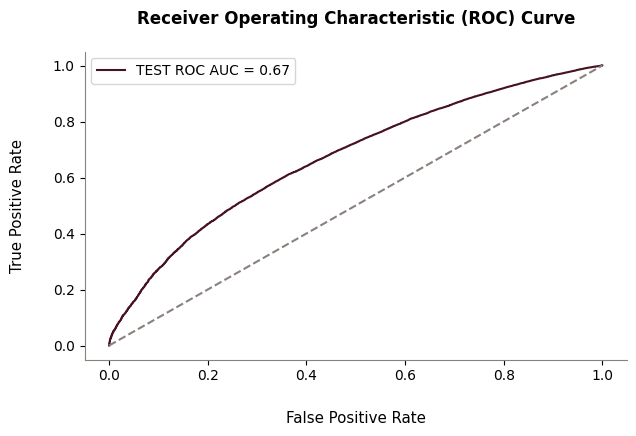

In [43]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(fpr, tpr, label=f'TEST ROC AUC = {roc_auc_test:.2f}', color='#461220')
ax.plot([0, 1], [0, 1], linestyle='--', color='#8a817c')  # Random guessing line.
ax.set_xlabel('False Positive Rate', fontsize=10.8, labelpad=20)
ax.set_ylabel('True Positive Rate', fontsize=10.8, labelpad=20)
ax.set_xticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold', fontsize=12, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#8a817c')
ax.spines['bottom'].set_color('#8a817c')
ax.grid(False)
ax.legend()

In [44]:
test_scores = pd.DataFrame()
test_scores['actual'] = y_test.reset_index(drop=True)
test_scores['probability_of_default'] = 1 - test_proba
sorted_test_scores = test_scores.sort_values(by=['probability_of_default'], ascending=False)
sorted_test_scores['cum_bad'] = (1 - sorted_test_scores['actual']).cumsum() / (1 - sorted_test_scores['actual']).sum()
sorted_test_scores['cum_good'] = sorted_test_scores['actual'].cumsum() / sorted_test_scores['actual'].sum()
sorted_test_scores['ks'] = np.abs(sorted_test_scores['cum_good'] - sorted_test_scores['cum_bad'])
ks_statistic_test = sorted_test_scores['ks'].max()

ks_statistic_test

np.float64(0.02597527137097888)

In [51]:
def scorecard(reference_categories, sumary_table):
    # Correção na criação do ref_categorie_score
    ref_categorie_score = {}
    for key, value in reference_categories.items():  # Use .items() para acessar chave e valor
        ref_categorie_score[key] = f"{key}_{value}"
    
    # O resto do código permanece igual
    score_ref_categorie = pd.DataFrame()  # Corrigido DataFrame com D maiúsculo
    score_ref_categorie['Dummy'] = list(ref_categorie_score.values())
    score_ref_categorie['Beta Coefficient'] = 0 
    score_ref_categorie['P-Value'] = 'reference category'
    score_ref_categorie['Wald Statistic'] = 'reference category'
    score_ref_categorie = score_ref_categorie.reset_index(drop=True)
    score_ref_categorie.index += 87

    sumary_table_score = sumary_table.reset_index().rename(columns={'index': 'Dummy'})
    scorecard = pd.concat([sumary_table_score, score_ref_categorie])
    scorecard = scorecard.sort_values(by=['Dummy']).reset_index(drop=True)
    min_score = 300
    max_score = 850

    scorecard['Independent Variable'] = scorecard['Dummy'].str.split('_').str[0]  # Simplificado
    
    # Corrigido min() e max()
    min_sum_cof = scorecard.groupby(['Independent Variable'])['Beta Coefficient'].min().sum()
    max_sum_cof = scorecard.groupby(['Independent Variable'])['Beta Coefficient'].max().sum()
    
    scorecard['Score'] = scorecard['Beta Coefficient'] * (max_score - min_score)/(max_sum_cof - min_sum_cof)
    
    # Corrigido acesso ao valor do intercept
    intercept = scorecard.loc[scorecard['Dummy'] == 'const', 'Beta Coefficient'].values[0]
    # Corrigido operador de atribuição
    scorecard.loc[scorecard['Dummy'] == 'const', 'Score'] = ((intercept - min_sum_cof)/(max_sum_cof - min_sum_cof)) * (max_score - min_score) + min_score

    scorecard['Score'] = scorecard['Score'].round()
    min_possible_score = scorecard.groupby(['Independent Variable'])['Score'].min().sum()
    max_possible_score = scorecard.groupby(['Independent Variable'])['Score'].max().sum()

    # Corrigido syntax do drop
    scorecard = scorecard.drop(columns=['Independent Variable'])

    return scorecard, min_possible_score, max_possible_score  # Corrigido nome da variável

In [52]:
score, min, max = scorecard(reference_categories, sumary_table)

In [53]:
score

,Dummy,Beta Coefficient,P-Value,Wald Statistic,Score
0,addr_state_AL_NM_NJ,0.085835,0.001809,9.734264,7.0
1,addr_state_AR_TN_MI_UT_VA_LA_PA_AZ_OH_RI_KY_DE_IN,0.156594,0.0,58.988791,13.0
2,addr_state_CA,0.086369,0.000061,16.062792,7.0
3,addr_state_MA_SD_GA_MN_WI_WA_OR_IL_CT,0.234418,0.0,121.741191,19.0
4,addr_state_MS_MT_SC_VT_KS_CO_AK_NH_WV_WY_ID_DC_ME,0.402736,0.0,203.70104,32.0
5,addr_state_NE_IA_NV_HI_FL,0.000000,reference category,reference category,0.0
6,addr_state_NY,0.093337,0.000134,14.577697,7.0
7,addr_state_OK_MO_MD_NC,0.103654,0.000044,16.699856,8.0
8,addr_state_TX,0.280432,0.0,113.173443,23.0
9,annual_inc_120.0K-150.0K,0.795018,0.0,245.648103,64.0


In [55]:
print(min)

299.0


In [58]:
print(max)

850.0
